In [178]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline  

Let's first build some python classes to help us out. 

In [179]:
class Arm():
    def __init__(self, prob):
        self.prob = prob
        
    def pull(self):
        return np.random.choice([0,1], 1, p = [1 - self.prob, self.prob])[0]

class Bandit():
    def __init__(self, probs):
        self.arms = {k:Arm(v) for k,v in enumerate(probs)}
    
    def pull_arm(self, arm_id):
        return self.arms[arm_id].pull()

With these classes defined we can make a bandit. 

In [180]:
probs = [0.1, 0.05, 0.2, 0.11]
n = 1000
bandit = Bandit(probs)

data = [] 
for _ in range(n):
    arm = np.random.choice(list(range(len(probs))))
    data.append([arm, bandit.pull_arm(arm), _])

In [181]:
df = pd.DataFrame(data, columns=['arm', 'score', 'time'])

In [182]:
agg = df.groupby(['arm', 'time']).agg([len, np.sum])['score'].reset_index()

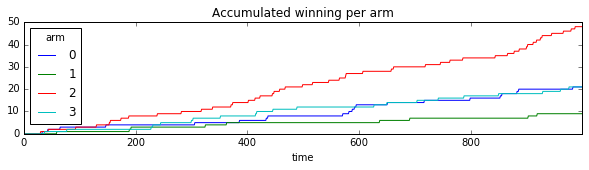

In [183]:
pltr = agg.pivot('time', 'arm')['sum'].fillna(0).cumsum()
pltr.plot(figsize=(10, 2), title = "Accumulated winning per arm")

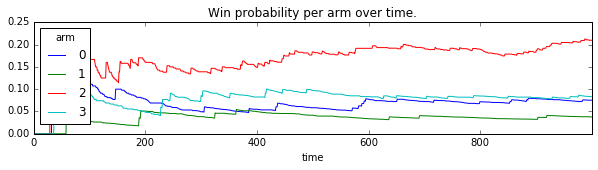

In [184]:
pltr = (pltr / agg.pivot('time', 'arm')['len'].fillna(0).cumsum())
_ = pltr.plot(figsize=(10, 2), title="Win probability per arm over time.")

In [185]:
total_profit = agg.pivot('time', 'arm')['sum'].cumsum().sum(axis = 1).max()
max_expected_profit = np.max(probs)*n
print("total profit is {}".format(total_profit))
print("total regret is {}".format(max_expected_profit - total_profit))

total profit is 48.0
total regret is 152.0


# Towards an Algorithm

This seems to work well enough, but let's turn it into an algorithm. We should be able to do something better than random. 

In [186]:
def pick_arm(counter, epsilon=0.05):
    if np.random.uniform() < epsilon:
        probs = [1.0 for _ in counter.keys()]
    else:
        probs = [(counter[_][0] + 0.001)/counter[_][1] for _ in counter.keys()] 
    print(probs)
    return np.random.choice(list(range(len(counter.keys()))), p = probs/np.sum(probs))

In [187]:
bandit = Bandit(probs)
counter = {arm:(1,1) for arm in range(len(probs))}
data = []
for _ in range(n):
    arm = pick_arm(counter, 1/(_+1))
    outcome = bandit.pull_arm(arm)
    counter[arm] = counter[arm][0] + outcome, counter[arm][1] + 1
    print('counter')
    print(counter)
    data.append([arm, bandit.pull_arm(arm), _])

[1.0, 1.0, 1.0, 1.0]
counter
{0: (1, 1), 1: (1, 2), 2: (1, 1), 3: (1, 1)}
[1.001, 0.50049999999999994, 1.001, 1.001]
counter
{0: (1, 2), 1: (1, 2), 2: (1, 1), 3: (1, 1)}
[0.50049999999999994, 0.50049999999999994, 1.001, 1.001]
counter
{0: (1, 2), 1: (1, 2), 2: (2, 2), 3: (1, 1)}
[1.0, 1.0, 1.0, 1.0]
counter
{0: (1, 3), 1: (1, 2), 2: (2, 2), 3: (1, 1)}
[0.33366666666666661, 0.50049999999999994, 1.0004999999999999, 1.001]
counter
{0: (1, 3), 1: (1, 3), 2: (2, 2), 3: (1, 1)}
[0.33366666666666661, 0.33366666666666661, 1.0004999999999999, 1.001]
counter
{0: (1, 3), 1: (1, 3), 2: (2, 2), 3: (1, 2)}
[0.33366666666666661, 0.33366666666666661, 1.0004999999999999, 0.50049999999999994]
counter
{0: (1, 3), 1: (2, 4), 2: (2, 2), 3: (1, 2)}
[0.33366666666666661, 0.50024999999999997, 1.0004999999999999, 0.50049999999999994]
counter
{0: (1, 3), 1: (2, 4), 2: (2, 3), 3: (1, 2)}
[1.0, 1.0, 1.0, 1.0]
counter
{0: (1, 3), 1: (3, 5), 2: (2, 3), 3: (1, 2)}
[0.33366666666666661, 0.60019999999999996, 0.6669999

In [188]:
df = pd.DataFrame(data, columns=['arm', 'score', 'time'])
agg = df.groupby(['arm', 'time']).agg([len, np.sum])['score'].reset_index()

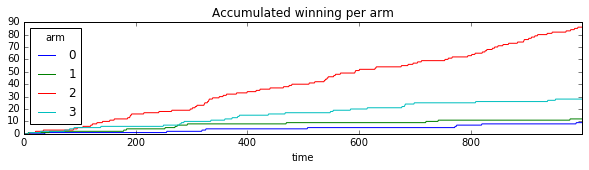

In [189]:
pltr = agg.pivot('time', 'arm')['sum'].fillna(0).cumsum()
_ = pltr.plot(figsize=(10, 2), title = "Accumulated winning per arm")

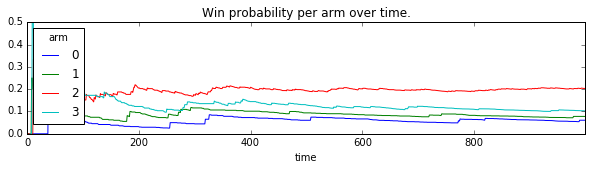

In [190]:
pltr = (pltr / agg.pivot('time', 'arm')['len'].fillna(0).cumsum())
_ = pltr.plot(figsize=(10, 2), title="Win probability per arm over time.")

In [191]:
total_profit = agg.pivot('time', 'arm')['sum'].cumsum().sum(axis = 1).max()
max_expected_profit = np.max(probs)*n
print("total profit is {}".format(total_profit))
print("total regret is {}".format(max_expected_profit - total_profit))



total profit is 86.0
total regret is 114.0


## Epsilon-first strategy
A pure exploration phase is followed by a pure exploitation phase. For $N$ trials in total, the exploration phase occupies $\epsilon N$ trials and the exploitation phase $(1-\epsilon )N$ trials. During the exploration phase, a lever is randomly selected (with uniform probability); during the exploitation phase, the best lever is always selected.

In [192]:
def pick_arm_epsilon_first(counter, time, N, epsilon=0.1):
    # if time less than eN then randomly select, else choose best and exploit
    if  time < epsilon*N:
        # explore all arms randomly
        probs = [1.0 for _ in counter.keys()]
        output = np.random.choice(list(range(len(counter.keys()))), p = probs/np.sum(probs))
    else:
        # select arm that is best performing and exploit
        probs = [(counter[_][0] + 0.001)/counter[_][1] for _ in counter.keys()]
        relative_probs = pd.DataFrame(probs/np.sum(probs), columns=['value'])
        output = relative_probs.idxmax(axis=0)[0]
    print('output = ' + str(output))    
    return output

In [193]:
bandit = Bandit(probs)
counter = {arm:(1,1) for arm in range(len(probs))}
data = []
for _ in range(n):
    arm = pick_arm_epsilon_first(counter, _, n, 0.5)
    outcome = bandit.pull_arm(arm)
    counter[arm] = counter[arm][0] + outcome, counter[arm][1] + 1
    data.append([arm, bandit.pull_arm(arm), _])

exploration
output = 1
exploration
output = 1
exploration
output = 3
exploration
output = 2
exploration
output = 1
exploration
output = 3
exploration
output = 0
exploration
output = 1
exploration
output = 1
exploration
output = 2
exploration
output = 3
exploration
output = 1
exploration
output = 2
exploration
output = 3
exploration
output = 0
exploration
output = 0
exploration
output = 1
exploration
output = 0
exploration
output = 1
exploration
output = 1
exploration
output = 3
exploration
output = 2
exploration
output = 0
exploration
output = 3
exploration
output = 3
exploration
output = 0
exploration
output = 1
exploration
output = 0
exploration
output = 2
exploration
output = 3
exploration
output = 3
exploration
output = 2
exploration
output = 2
exploration
output = 1
exploration
output = 1
exploration
output = 3
exploration
output = 0
exploration
output = 3
exploration
output = 2
exploration
output = 3
exploration
output = 0
exploration
output = 1
exploration
output = 2
exploration

In [194]:
df = pd.DataFrame(data, columns=['arm', 'score', 'time'])
agg = df.groupby(['arm', 'time']).agg([len, np.sum])['score'].reset_index()

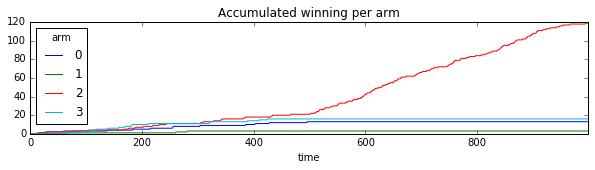

In [195]:
pltr = agg.pivot('time', 'arm')['sum'].fillna(0).cumsum()
_ = pltr.plot(figsize=(10, 2), title = "Accumulated winning per arm")

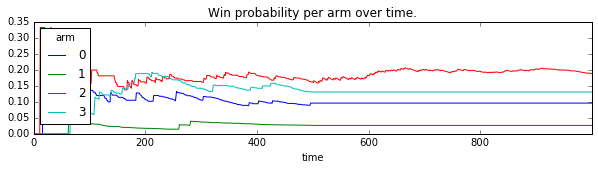

In [196]:
pltr = (pltr / agg.pivot('time', 'arm')['len'].fillna(0).cumsum())
_ = pltr.plot(figsize=(10, 2), title="Win probability per arm over time.")

In [197]:
total_profit = agg.pivot('time', 'arm')['sum'].cumsum().sum(axis = 1).max()
max_expected_profit = np.max(probs)*n
print("total profit is {}".format(total_profit))
print("total regret is {}".format(max_expected_profit - total_profit))

total profit is 119.0
total regret is 81.0
